In [1]:
!python -V

Python 3.10.6


# Abdominal Compliance Pression-Volume Curve Fitting
In this notebook, I fit a model to predict the abdominal compliance of pediatric patients and support surgeons dealing with laparoscopy surgery. 
The abdominal compliance ...

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize as scikit_normalize
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline

In [3]:
# import the dataset from file system
url="https://raw.githubusercontent.com/fcrlab-unime/pediatric-laparoscopy-dataset/main/laparoscopy-data.csv"
df = pd.read_csv(url)

## Venegas Equation
The model is based on the Venegas equation as firstly reported in the following paper (read it [here](https://pubmed.ncbi.nlm.nih.gov/9451661/)):
```
Venegas JG, Harris RS, Simon BA
A comprehensive equation for the pulmonary pressure-volume curve.
J Appl Physiol (1985)
1998 Jan
84(1):389-95
doi: 10.1152/jappl.1998.84.1.389
PMID: 9451661
```
Venegas et Al. intended to study the elastic properties (compliance) of the lungs and proposed to fit an equation to experimental or clinical pressure-volume data. The equation provides a systematic method to characterize the curve and derive objective paremeters from them. <br>
Authors proposed a sigmoidal equation that fits inflation and deflation limbs of the pressure-volume curve, defining:
$$
V = a + \frac{b}{1+ e^{\frac{-(P-c)}{d}}}
$$
where:
- *V* is inflation or absolute lung volume
- *P* is airway opening or transpulmonary pressure
- *a* has units of volume and corresponds to the lower asymptote volume
- *b* has units of volume and corresponds to the vital capacity or the total change in volume between the lower and the upper asymptotes
- *c* is the pressure at the inflection point of the sigmoidal curve and also corresponds to the pressure at the point of highest compliance
- *d* is proportional to the pressure range within which most of the volume change takes place

The following code implements the Venegas equation, defining *a*, *b*, *c*, and *d* as fitting parameters.

In [4]:
def venegas(P, a, b, c, d):
    return a + b/(1+np.exp(-(P-c)/d))

In [5]:
volumes = np.array([
        np.array(df['Volume TOT 0%'] - df['Volume TOT 0%']),
        np.array(df['Volume TOT 35%'] - df['Volume TOT 0%']),
        np.array(df['Volume TOT 50%'] - df['Volume TOT 0%']),
        np.array(df['Volume TOT 75%'] - df['Volume TOT 0%']),
        np.array(df['Volume TOT 100%'] - df['Volume TOT 0%'])
])
volumes = np.transpose(volumes)

pressures = np.array([
        np.array(df['IAP 0% mmHg'].apply(lambda x: x*1.36)),
        np.array(df['IAP 35% mmHg'].apply(lambda x: x*1.36)),
        np.array(df['IAP 50% mmHg'].apply(lambda x: x*1.36)),
        np.array(df['IAP 75% mmHg'].apply(lambda x: x*1.36)),
        np.array(df['IAP 100% mmHg'].apply(lambda x: x*1.36))
])
pressures = np.transpose(pressures)

parameters = np.array([
    np.array([12, df.iloc[0]['Volume TOT 100%'], df.iloc[0]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[1]['Volume TOT 100%'], df.iloc[1]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[2]['Volume TOT 100%'], df.iloc[2]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[3]['Volume TOT 100%'], df.iloc[3]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[4]['Volume TOT 100%'], df.iloc[4]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[5]['Volume TOT 100%'], df.iloc[5]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[6]['Volume TOT 100%'], df.iloc[6]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[7]['Volume TOT 100%'], df.iloc[7]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[8]['Volume TOT 100%'], df.iloc[8]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[9]['Volume TOT 100%'], df.iloc[9]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[10]['Volume TOT 100%'], df.iloc[10]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[11]['Volume TOT 100%'], df.iloc[11]['IAP 100% mmHg'], 3.5]), 
    np.array([12, df.iloc[12]['Volume TOT 100%'], df.iloc[12]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[13]['Volume TOT 100%'], df.iloc[13]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[14]['Volume TOT 100%'], df.iloc[14]['IAP 100% mmHg'], 3.5]),
    np.array([12, df.iloc[15]['Volume TOT 100%'], df.iloc[15]['IAP 100% mmHg'], 3.5]),
])

In [6]:
print("Pressure shape:",pressures.shape)
print("Volumes shape:", volumes.shape)
num_samples = volumes.shape[0]

Pressure shape: (16, 5)
Volumes shape: (16, 5)


Text(0.5, 1.02, 'Data points')

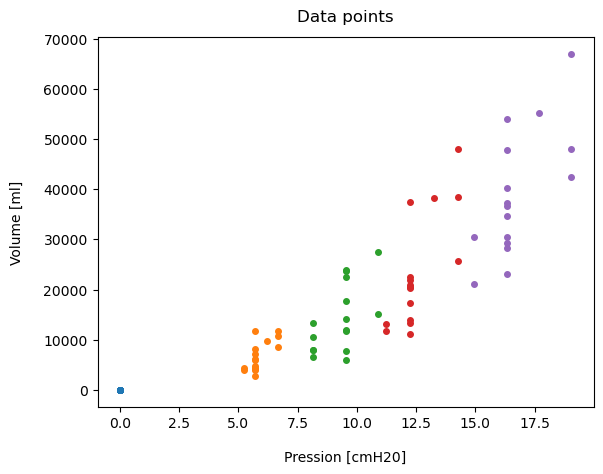

In [7]:
plt.plot(pressures, volumes, 'o', markersize=4, label='data')
plt.xlabel("Pression [cmH20]", labelpad=14)
plt.ylabel("Volume [ml]", labelpad=14)
plt.title("Data points", y=1.02)

In [8]:
#pressures_average = [sum(sub_list) / len(sub_list) for sub_list in zip(*pressures)]
#volumes_average = [sum(sub_list) / len(sub_list) for sub_list in zip(*volumes)]
#parameters_average = [sum(sub_list) / len(sub_list) for sub_list in zip(*parameters)]

In [9]:
# https://math.stackexchange.com/questions/2512852/denormalization-of-numpy-matrix-is-not-correct

def normalize_min_max(x, x_min, x_max, between = (0,1)):
    a, b = between
    num = (x - x_min) * (b-a)
    den = (x_max - x_min)
    return a + (num / den)
normalize = np.vectorize(normalize_min_max)

def denormalize_min_max(x1, x_min, x_max, between = (0,1)):
    a, b = between
    num = (x_max - x_min) * (x1-a)
    den = b-a
    return (num / den) + x_min
denormalize = np.vectorize(denormalize_min_max)

In [10]:
volume_min = np.amin(volumes)
volume_max = np.amax(volumes)

pressure_min = np.amin(pressures)
pressure_max = np.amax(pressures)

In [11]:
volumes_normalized = normalize(volumes, volume_min, volume_max)
pressures_normalized = normalize(pressures, pressure_min, pressure_max)

parameters_normalized = np.empty(parameters.shape)
parameters_normalized[:, 0] = normalize(parameters[:, 0], volume_min, volume_max)
parameters_normalized[:, 1] = normalize(parameters[:, 1], volume_min, volume_max)
parameters_normalized[:, 2] = normalize(parameters[:, 2], pressure_min, pressure_max)
parameters_normalized[:, 3] = normalize(parameters[:, 3], pressure_min, pressure_max)

In [12]:
# volumes_normalized = scikit_normalize(volumes)
# pressures_normalized = scikit_normalize(pressures)
# parameters_normalized = scikit_normalize(parameters)

Text(0.5, 1.02, 'Normalized Data points')

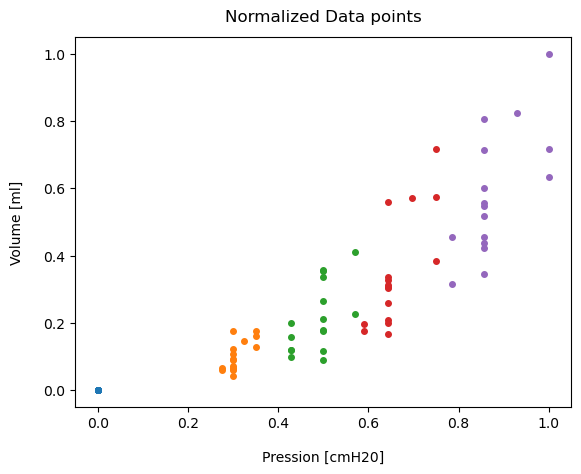

In [13]:
plt.plot(pressures_normalized, volumes_normalized, 'o', markersize=4, label='data')
plt.xlabel("Pression [cmH20]", labelpad=14)
plt.ylabel("Volume [ml]", labelpad=14)
plt.title("Normalized Data points", y=1.02)

In [14]:
pressures_normalized_average = [sum(sub_list) / len(sub_list) for sub_list in zip(*pressures_normalized)]
volumes_normalized_average = [sum(sub_list) / len(sub_list) for sub_list in zip(*volumes_normalized)]
parameters_normalized_average = [sum(sub_list) / len(sub_list) for sub_list in zip(*parameters_normalized)]

The SciPy open source library provides the curve_fit() function for curve fitting via nonlinear least squares.

In [15]:
# https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python

popt_dogbox, _ = curve_fit(venegas, pressures_normalized_average, volumes_normalized_average, parameters_normalized_average, method='dogbox', maxfev=5000)
popt_trf, _ = curve_fit(venegas, pressures_normalized_average, volumes_normalized_average, parameters_normalized_average, method='trf', maxfev=5000)
popt_lm, _ = curve_fit(venegas, pressures_normalized_average, volumes_normalized_average, parameters_normalized_average, method='lm', maxfev=5000)

In [16]:
# https://stackoverflow.com/questions/69759738/getting-a-negative-r-squared-value-with-curve-fit

pred = venegas(pressures_normalized, *popt_trf)
ss_total = np.sum(volumes_normalized**2)  # Not deviation from mean.
ss_resid = np.sum((volumes_normalized - pred)**2)
pseudo_r_squared = 1 - ss_resid/ss_total
print("The pseudo-R2 (trf model) is %s" % (pseudo_r_squared))

pred = venegas(pressures_normalized, *popt_dogbox)
ss_total = np.sum(volumes_normalized**2)  # Not deviation from mean.
ss_resid = np.sum((volumes_normalized - pred)**2)
pseudo_r_squared = 1 - ss_resid/ss_total
print("The pseudo-R2 (dogbox model) is %s" % (pseudo_r_squared))

pred = venegas(pressures_normalized, *popt_lm)
ss_total = np.sum(volumes_normalized**2)  # Not deviation from mean.
ss_resid = np.sum((volumes_normalized - pred)**2)
pseudo_r_squared = 1 - ss_resid/ss_total
print("The pseudo-R2 (lm model) is %s" % (pseudo_r_squared))

The pseudo-R2 (trf model) is 0.9223223670988606
The pseudo-R2 (dogbox model) is 0.922322367275149
The pseudo-R2 (lm model) is 0.9223223674228269


In [17]:
mse_trf = mean_squared_error(volumes_normalized, venegas(pressures_normalized, *popt_trf))
print("The MSE (trf model) is %s" % (mse_trf))

mse_dogbox = mean_squared_error(volumes_normalized, venegas(pressures_normalized, *popt_dogbox))
print("The MSE (dogbox model) is %s" % (mse_dogbox))

mse_lm = mean_squared_error(volumes_normalized, venegas(pressures_normalized, *popt_lm))
print("The MSE (lm model) is %s" % (mse_lm))

The MSE (trf model) is 0.009195363744137746
The MSE (dogbox model) is 0.009195363723268977
The MSE (lm model) is 0.009195363705787097


In [18]:
mean_squared_error(volumes_normalized, venegas(pressures_normalized, *popt_trf), squared=False)
print("The RMSE (trf model) is %s" % (mse_trf))

mean_squared_error(volumes_normalized, venegas(pressures_normalized, *popt_dogbox), squared=False)
print("The RMSE (dogbox model) is %s" % (mse_dogbox))

mean_squared_error(volumes_normalized, venegas(pressures_normalized, *popt_lm), squared=False)
print("The RMSE (lm model) is %s" % (mse_lm))

The RMSE (trf model) is 0.009195363744137746
The RMSE (dogbox model) is 0.009195363723268977
The RMSE (lm model) is 0.009195363705787097


In [19]:
print(popt_trf)
print(popt_dogbox)
print(popt_lm)

[-0.08047052  1.61279022  0.9993073   0.33804181]
[-0.08047053  1.61279042  0.99930737  0.33804183]
[-0.08047053  1.61279043  0.99930737  0.33804183]


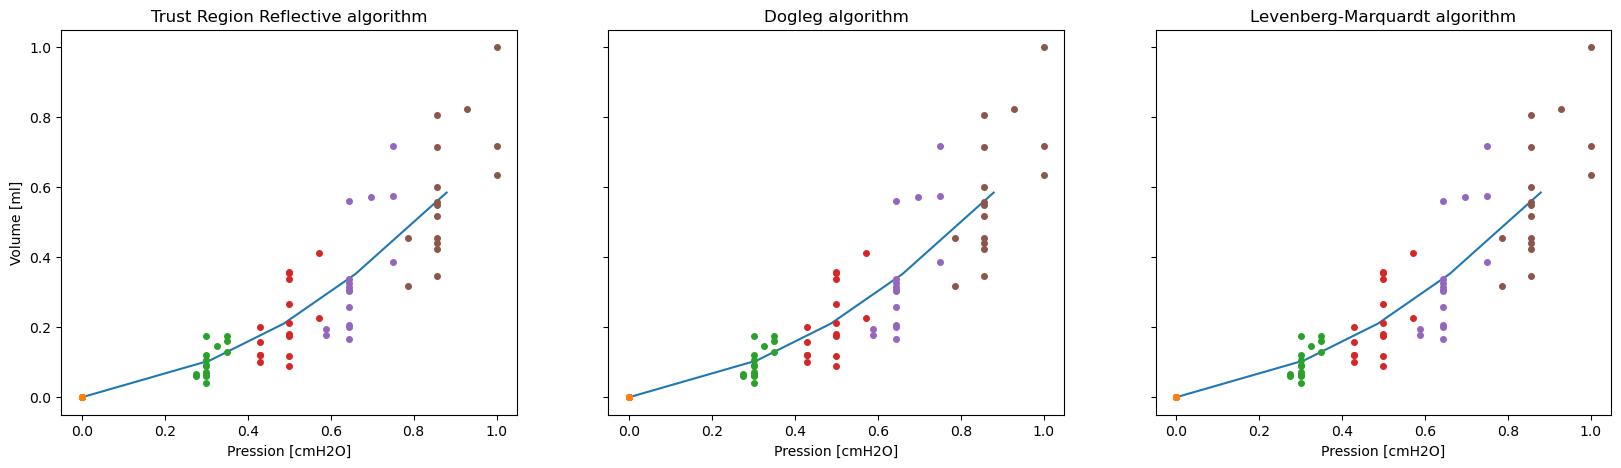

In [20]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20,5))

y = venegas(pressures_normalized_average, *popt_trf)
axs[0].plot(pressures_normalized_average, y, label='fitted model')
axs[0].set_title('Trust Region Reflective algorithm')

y = venegas(pressures_normalized_average, *popt_dogbox)
axs[1].plot(pressures_normalized_average, y, label='fitted model')
axs[1].set_title('Dogleg algorithm')

y = venegas(pressures_normalized_average, *popt_lm)
axs[2].plot(pressures_normalized_average, y, label='fitted model')
axs[2].set_title('Levenberg-Marquardt algorithm')

for ax in axs:
    ax.plot(pressures_normalized, volumes_normalized, 'o', markersize=4, label='data')
    ax.set(xlabel='Pression [cmH2O]', ylabel='Volume [ml]')
    ax.label_outer()

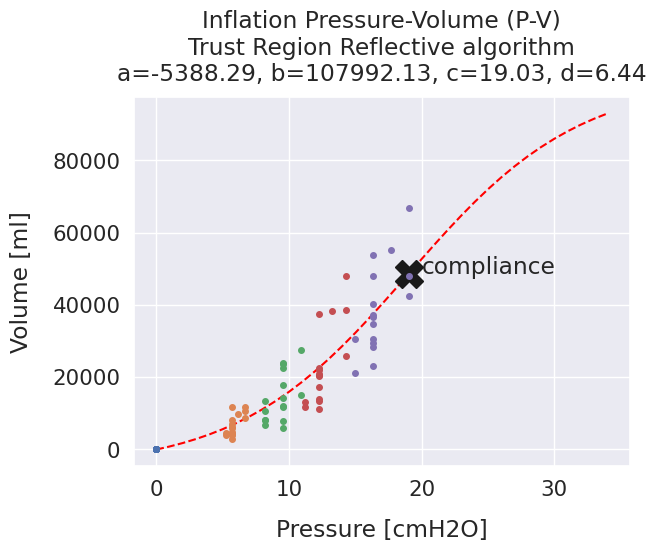

In [21]:
a, b, c, d = popt_trf
a = denormalize(a, volume_min, volume_max)
b = denormalize(b, volume_min, volume_max)
c = denormalize(c, pressure_min, pressure_max)
d = denormalize(d, pressure_min, pressure_max)

x_line = np.arange(0, 35, 1)
y_line = venegas(x_line, a, b, c, d)

sns.set(font_scale=1.4)
plt.plot(x_line, y_line, '--', color='red')
plt.xlabel("Pressure [cmH2O]", labelpad=14)
plt.ylabel("Volume [ml]", labelpad=14)
plt.title("Inflation Pressure-Volume (P-V)\nTrust Region Reflective algorithm\na=%.2f, b=%.2f, c=%.2f, d=%.2f" % (a,b,c,d), y=1.02)

plt.plot(c,venegas(c, a, b, c, d),'kX', markersize=20) 
plt.annotate("compliance", (c+1, venegas(c, a, b, c, d)))

plt.plot(pressures, volumes, 'o', markersize=4, label='data')

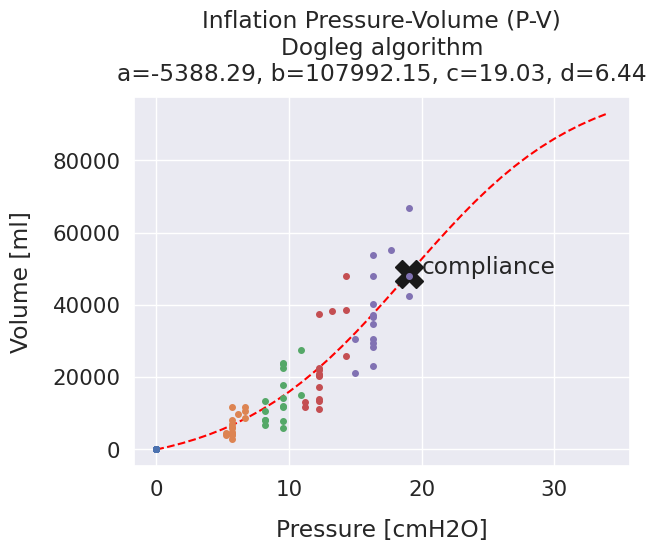

In [22]:
a, b, c, d = popt_dogbox
a = denormalize(a, volume_min, volume_max)
b = denormalize(b, volume_min, volume_max)
c = denormalize(c, pressure_min, pressure_max)
d = denormalize(d, pressure_min, pressure_max)

x_line = np.arange(0, 35, 1)
y_line = venegas(x_line, a, b, c, d)

sns.set(font_scale=1.4)
plt.plot(x_line, y_line, '--', color='red')
plt.xlabel("Pressure [cmH2O]", labelpad=14)
plt.ylabel("Volume [ml]", labelpad=14)
plt.title("Inflation Pressure-Volume (P-V)\nDogleg algorithm\na=%.2f, b=%.2f, c=%.2f, d=%.2f" % (a,b,c,d), y=1.02)

plt.plot(c,venegas(c, a, b, c, d),'kX', markersize=20) 
plt.annotate("compliance", (c+1, venegas(c, a, b, c, d)))

plt.plot(pressures, volumes, 'o', markersize=4, label='data')

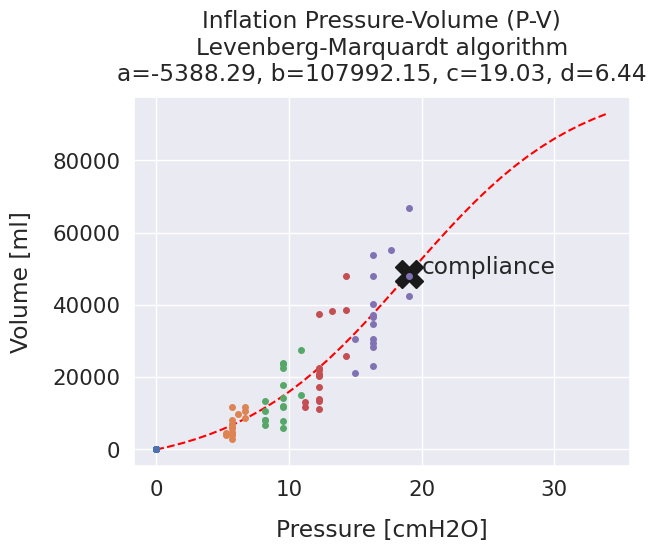

In [23]:
a, b, c, d = popt_lm
a = denormalize(a, volume_min, volume_max)
b = denormalize(b, volume_min, volume_max)
c = denormalize(c, pressure_min, pressure_max)
d = denormalize(d, pressure_min, pressure_max)

x_line = np.arange(0, 35, 1)
y_line = venegas(x_line, a, b, c, d)

sns.set(font_scale=1.4)
plt.plot(x_line, y_line, '--', color='red')
plt.xlabel("Pressure [cmH2O]", labelpad=14)
plt.ylabel("Volume [ml]", labelpad=14)
plt.title("Inflation Pressure-Volume (P-V)\nLevenberg-Marquardt algorithm\na=%.2f, b=%.2f, c=%.2f, d=%.2f" % (a,b,c,d), y=1.02)

plt.plot(c,venegas(c, a, b, c, d),'kX', markersize=20) 
plt.annotate("compliance", (c+1, venegas(c, a, b, c, d)))

plt.plot(pressures, volumes, 'o', markersize=4, label='data')